# Importing all the required dependencies

In [1]:
import torch
import torch.nn.functional as F
import random
from matplotlib import pyplot as plt
from tqdm import tqdm

# Importing the dataset

In [2]:
names = open('./names.txt','r').read().split('\n')
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
# dictionary to convert characters to index and vice versa
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 # special token for padding which indicate the start and end of the sentence
itos = {i:s for s,i in stoi.items()}

In [4]:
random.shuffle(names)

# Train, Test, Validation split on the Dataset

In [5]:
def build_dataset(data,train_percentage,block_size):
    train_size = int(len(names) * train_percentage)
    dev_size = int(len(names) * (1-train_percentage) / 2)
    def _getdata(data, start, end, block_size):
        X, Y = [], []
        for name in data[start:end]:
            context = [0] * block_size
            for ch in name + '.':
                ix = stoi[ch]
                X.append(context[:])
                Y.append(ix)
                context = context[1:] + [ix]
        X = torch.tensor(X)
        Y = torch.tensor(Y)
        return X, Y
    return _getdata(data,0,train_size,block_size), _getdata(data,train_size,train_size+dev_size,block_size), _getdata(data,train_size+dev_size,len(data),block_size)

In [6]:
train_data, dev_data, test_data = build_dataset(names,0.8,block_size=3)
train_data[0].shape, dev_data[0].shape, test_data[0].shape

(torch.Size([182405, 3]), torch.Size([22817, 3]), torch.Size([22924, 3]))

In [7]:
Xtr, Ytr = train_data
Xdev, Ydev = dev_data
Xtest, Ytest = test_data

# Model

In [8]:
class Model:
    class ModelConfig:
        def __init__(self, block_size, embedding_size, hidden_size, output_size=27, manual_seed=42):
            self.block_size = block_size
            self.embedding_size = embedding_size
            self.hidden_size = hidden_size  # tanh layer size
            self.output_size = output_size  # vocabulary size
            self.manual_seed = manual_seed

    def __init__(self, modelConfig,device = 'cpu'):
        self.modelConfig = modelConfig
        self.device = 'cpu'
        if(device == 'cuda'):
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            print(f'GPU: {torch.cuda.get_device_properties(self.device).name}')

        g = torch.Generator(device=self.device).manual_seed(modelConfig.manual_seed)
        self.C = torch.rand((modelConfig.output_size, modelConfig.embedding_size), generator=g, device=self.device)
        self.W1 = torch.rand((modelConfig.embedding_size * modelConfig.block_size, modelConfig.hidden_size), generator=g, device=self.device)
        self.b1 = torch.rand((modelConfig.hidden_size), generator=g, device=self.device)
        self.W2 = torch.rand(modelConfig.hidden_size, modelConfig.output_size, generator=g, device=self.device)
        self.b2 = torch.rand(modelConfig.output_size, generator=g, device=self.device)
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad = True
        n_parameters = sum(p.numel() for p in self.parameters)
        print(f'Number of parameters: {n_parameters}')
        print(f'Device: {self.device}')
            
        self.lossi = []
        self.stepi = []
        self.steps = 0

    def train(self, X, Y, nsteps, lr=0.1, batch_size=32):
        X, Y = X.to(self.device), Y.to(self.device)
        for i in tqdm(range(nsteps)):
            # mini-batch
            ix = torch.randint(0, len(X), (batch_size,), device=self.device)
            xb = X[ix]
            yb = Y[ix]

            # forward pass
            emb = self.C[xb]
            h = torch.tanh(emb.view(-1, self.modelConfig.block_size * self.modelConfig.embedding_size) @ self.W1 + self.b1)
            logits = h @ self.W2 + self.b2
            loss = F.cross_entropy(logits, yb)

            # backward pass
            loss.backward()
            for p in self.parameters:
                p.data -= lr * p.grad
                p.grad.zero_()

            # storing loss and steps for visualization
            self.lossi.append(loss.item())
            self.stepi.append(self.steps)
            self.steps += 1

        plt.plot(self.stepi, self.lossi)
        print(f'Loss: {loss.item()}')
        plt.show()

    def Loss(self,X,Y):
        X, Y = X.to(self.device), Y.to(self.device)
        with torch.no_grad():
            emb = self.C[X]
            h = torch.tanh(emb.view(-1, self.modelConfig.block_size*self.modelConfig.embedding_size) @ self.W1 + self.b1)
            logits = h @ self.W2 + self.b2
            loss = F.cross_entropy(logits,Y)
        return loss.item()
    def sample(self,n):
        names = []
        g = torch.Generator(device=self.device).manual_seed(self.modelConfig.manual_seed)
        for i in range(n):
            context = [0] * self.modelConfig.block_size
            out = []
            while True:
                emb = self.C[torch.tensor([context])]
                h = torch.tanh(emb.view(1, -1) @ self.W1 + self.b1)
                logits = h @ self.W2 + self.b2
                probs = F.softmax(logits,dim=1)
                ix = torch.multinomial(probs,num_samples=1,generator=g).item()
                context = context[1:] + [ix]
                if ix == 0:
                    break
                out.append(ix)
            name = ''.join([itos[i] for i in out])
            names.append(name)
        return names

# Model: Block Size = 3, Embedding Size = 2

In [9]:
model1_config = Model.ModelConfig(block_size=3, embedding_size=2, hidden_size=300)

In [10]:
model1 = Model(model1_config)

Number of parameters: 10281
Device: cpu


## Before Training

### Sampling before training

In [11]:
model1.sample(10)

['ygogyghhvfgghhovhgohhgfggohyfggfgvhggghggggofhfghofgihhghfhghghhhogggoygjovgohghggooghgffggffhhvhgfggohogggggghfghghgvofofggfvggghggghoovhvghogofyfggfhghgghhghgvfghhhfffggggghfahoghggohgghghhfgggfoghgghhoxffhggyfggggghhiohggfhhhghofggogfaffovhhfhgggfvgvhggggggghgfgfgfhvgohoohggofayfgvghhohghjhhghgghhhogfgghghggogghfgggvffggfggyfghhgggyohfghghghhgghhhigffggoghvhfffgohgoghhfghhvohghhggohgvhhghggfggghggfghgoghgivgoghvgghvhhhfggvghgggjgggfvgghhhgvhghghvfgfhggfggggggjgggg',
 'ghghggoghgoghhhhhfgjiogffggghgghvhfhhhhhvhfighgghggoahhffgggghogghfggggioghfgfhohghghfghfggghfhggfgfoggoohgghhohfggggggfgggghfggghvvgihfhgygyggfggghgofhoghhfggfghhghvvfggfgohgoghoghhgghfgofgghohfgghohvhgghvggghhhighhggvgfgofhgggoghghgoggvhgogggghggvhagfjgghhhgggggiggfgoffhhgfgghfviohhfofhgfvhffgjhgggfofggggyghggvfoogggggghgoggfghfihgfhhghggofgvogggghfhgghhghghhfgfhhhhfhhfvvhghgggghghgghfgffhffhovfoghgghfgggggofhgghhfogfgfgvgfhvvgghhgvgjgggggfghfghvggfhhgfghhgfgifjhhghfohgghfhgffygfgoggghgvghgvhgggogggoggggggggffhghfg

### Embeddings visualization before training

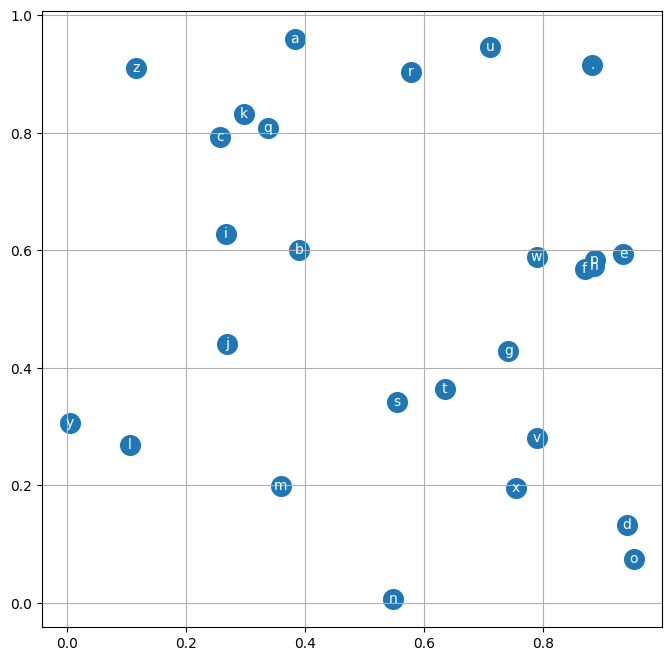

In [12]:
plt.figure(figsize = (8,8))
plt.scatter(model1.C[:,0].data,model1.C[:,1].data,s=200)
for i in range(len(model1.C)):
    plt.text(model1.C[i,0].item(),model1.C[i,1].item(),itos[i],ha = 'center',va = 'center', color= 'white')
plt.grid('minor')

## Model Training

100%|██████████| 50000/50000 [00:34<00:00, 1435.33it/s]


Loss: 2.007171392440796


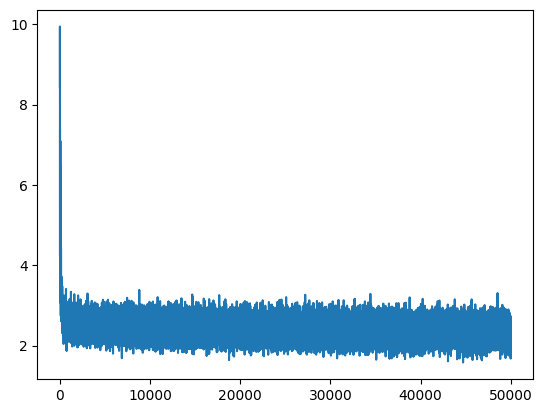

In [13]:
step = 50000
lr = 0.1
model1.train(Xtr,Ytr,step,lr)

100%|██████████| 15000/15000 [00:09<00:00, 1635.56it/s]


Loss: 2.0699782371520996


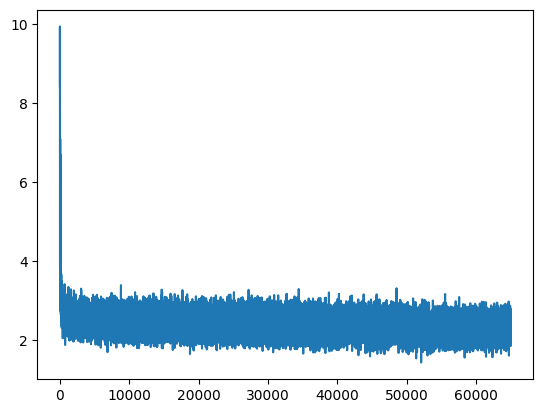

In [14]:
step = 15000 
lr = 0.01 # learning rate decay
model1.train(Xtr,Ytr,step,lr)

## Loss Calculation

In [15]:
model1.Loss(Xtr,Ytr),model1.Loss(Xdev,Ydev), model1.Loss(Xtest,Ytest)

(2.2691636085510254, 2.2890782356262207, 2.2798914909362793)

## Visualizing the embeddings

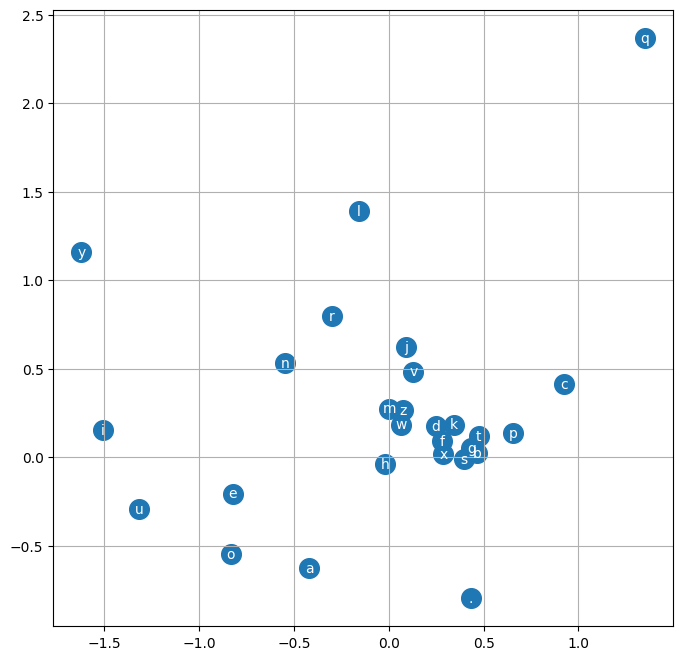

In [16]:
plt.figure(figsize = (8,8))
plt.scatter(model1.C[:,0].data,model1.C[:,1].data,s=200)
for i in range(len(model1.C)):
    plt.text(model1.C[i,0].item(),model1.C[i,1].item(),itos[i],ha = 'center',va = 'center', color= 'white')
plt.grid('minor')

## Sampling from the trained model

In [17]:
model1.sample(10)

['yansyanne',
 'amen',
 'logkismani',
 'jyn',
 'tryandanten',
 'ena',
 'daya',
 'jian',
 'abkelea',
 'lon']